## Task/End goal
> Be able to classify CODM users as satsfied/dissatisfied based on their review

In [1]:
import re
import pandas as pd
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data = pd.read_csv("Call Of Duty.csv")

In [3]:
data.head()

,reviews,ratings
0,I've been playing for years now and it's been ...,4
1,An annoying experience all round. Ever since t...,1
2,"I love the game though. It's close to real, bu...",3
3,I've been playing for years now and it's been ...,4
4,An annoying experience all round. Ever since t...,1


## EDA/Feature engineering

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  3882 non-null   object
 1   ratings  3882 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.8+ KB


In [5]:
data.isna().sum()

reviews    0
ratings    0
dtype: int64

In [6]:
data.describe()

,ratings
count,3882.000000
mean,3.202473
std,1.572016
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,5.000000


In [7]:
# Classifying reviews as binary (Satisfied =1, dissatisfied = 0) and creation of new column
# Satisfied user == 3+ stars rating, dissatisfied == 2< stars rating 
data["satisfied"] = data["ratings"].apply(lambda x: 1 if x >=3 else 0)

In [8]:
data.head()

,reviews,ratings,satisfied
0,I've been playing for years now and it's been ...,4,1
1,An annoying experience all round. Ever since t...,1,0
2,"I love the game though. It's close to real, bu...",3,1
3,I've been playing for years now and it's been ...,4,1
4,An annoying experience all round. Ever since t...,1,0


In [9]:
# users grouped by satisfaction status
reviews_by_satisfaction = data.groupby("satisfied")

# number of satisfied and unsatisfied users
reviews_by_satisfaction["satisfied"].count()

satisfied
0    1382
1    2500
Name: satisfied, dtype: int64

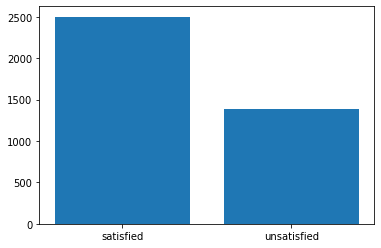

In [10]:
# Visualization of satisfide/unsatisfied ratings count

satisfied = reviews_by_satisfaction.get_group(1)
satisfied = satisfied["ratings"].count()

unsatisfied = reviews_by_satisfaction.get_group(0)
unsatisfied = unsatisfied["ratings"].count()

plt.bar(["satisfied", "unsatisfied"], [satisfied, unsatisfied])
plt.show()

In [11]:
# Making all texts lowercase.
data["reviews"] = data["reviews"].apply(lambda x: x.lower())

# Removing numbers.
data["reviews"] = data["reviews"].apply(lambda x: re.sub(r'[0-9]+', "", x))

# Removing white space
data["reviews"] = data["reviews"].apply(lambda x: x.strip())

# Removing special characters.
data["reviews"] = data["reviews"].apply(lambda x: x.replace(",", " ").replace(":", " ").replace(".", " ")
.replace("'", " ").replace("%", " ").replace(";", " ").replace("/", " ").replace('"', " ").replace("(", " ")
.replace(")", " ").replace("!", " ").replace("+", " ").replace("@", " ").replace("*", " ").replace("$", " ")
.replace("&", " ").replace("-", " ").replace("?", " ").replace("#", " ").replace("  ", " ").replace("£", " ")
.replace("_", " ").replace(" 🏽", " ").replace("\n", " ").replace("`", " "))

# replacing emojis with text.
# These emojis are emojis that I found to be most common to CODM reviews.
data["reviews"] = data["reviews"].apply(lambda x: x.replace("😎", " cool_face ").replace("😴", " sleepy_face ")
.replace("👍", " thumbs_up ").replace("👎", " thumbs_down ").replace("👌", " nice ").replace("🖕", " middle_finger ")
.replace("😆", " excitement ").replace("😅", " awkward ").replace("⭐", " star ").replace("💯", " approval ")
.replace("🤘", " cool ").replace("😉", " wink_face ").replace("❤", " love ").replace("😁", " cheer ")
.replace("🎮", " controller ").replace("🌟", " glowing_star ").replace("😂", " laughing_face ")
.replace("🙃", " upside-down-face").replace("🤭", " surprise_face ").replace("😝", " playful_face ")
.replace("😩", " exhaustion_face ").replace("❤️", " love ").replace("😍", " adoration ").replace("🙏", " pray ")
.replace("🙄", " rolling_eyes ").replace("😭", " crying_face ").replace("😑", " neutral_face ").replace("😏", " smirk_face ")
.replace("😡", " angry_face ").replace("😪", " sleepy_face ").replace("😓", " frustration_face ").replace("😀", " cheer_face ")
.replace("😒", " unasumed_face ").replace(" 🏝", " desert_island ").replace("🥴", " woozy_face ").replace("😊", " smiling_face ")
.replace("🥰", " feeling_loved ").replace("😃", " cheer_face ").replace("🤬",  " being_vulgar ").replace("🥺", " pleeding_face ")
.replace("🤣", " floor_laughing ").replace("😔", " dissapointed_face ").replace("🤞", " for_luck ").replace("🤡", " clown_face ")
.replace("😤", " highly_annoyed ").replace("👿", " angry_face_with_horns ").replace("🙂", " weird_smile ").replace("😊", " happy ")
.replace("💪", " flexed_biceps ").replace("🤯", " mind_blown ").replace("📌", "pin").replace("😋", " tongue_out ")
.replace("🤔", " thinking_emoji ").replace("😥", " sad_but_relieved_face ").replace("😞", " disappointed_face ")
.replace("😕", " confused_face ").replace("💖", " sparkling_heart ").replace("💋", " kiss ").replace("👹", " devil_face ")
.replace("👏", " clap_emoji ").replace("🤟", " i_love_you ").replace("🤷", " giving_up ").replace("🥵",  "hot_face ")
.replace("😌", " relieved_face ").replace("😳", " flushed_face ").replace("🔥", " fire_emoji ").replace("🛑", " stop_sign ")
.replace("💕", " two_hearts ").replace("😣", " persevering_face ").replace("☹️", " sad_face ").replace("🙌", " raising_hands ")
.replace("😛", " tongue_out ").replace("🤧", " sneezing_face ").replace("😠", " angry_face ").replace("😕",  "confused_face ")
.replace("🚫", " stop_sign ").replace("🧢", " cap ").replace("❗", " exclamation ").replace("🤩", " star_eyes ").replace("😐", " bored_face ")
.replace("🤑", " money_eyes ").replace("⚠️", " caution_sign ").replace("🌦️", " rainy_weather ").replace("🔆", " high_brightness ")
.replace("💙", " blue_heart ").replace("✌️", " peace_sign ").replace("💀", " skull").replace("😜", " wink ").replace("🤗", " hugging_face ")
.replace("💣", " bomb ").replace("💝", " wrapped_heart ").replace("♥️", " love ").replace("😢", " sad_face ").replace("📱", " phone ")
.replace("🥳", " celebrate ").replace("💞", " rolling_hearts ").replace("👊", " fist ").replace("💰", " money_bag ").replace("💔", " heart_break ")
.replace("✊🏾", " black_fist_up ").replace("😬", " discomfort ").replace("🤦‍♂️", " face_palm ").replace("🤪", " goofy_face ")
.replace("📢", " hand_horn ").replace("💥", " bang ").replace("🤍", " white_heart ").replace("🧡", " orange_heart ").replace("😘", " kiss ")
.replace("☺️", " smiling_face ").replace("🎯", " on_target ").replace("💜", " purple_heart ").replace("😫", " weary_face ")
.replace("🎉", " celebration ").replace("👋", " hand_wave ").replace("🤙", " call_me_hand ").replace("🤢", " feeling_sick ")
.replace("😟", " sad_face "))

# word tokenization
text_tokens = data["reviews"].apply(lambda review : word_tokenize(review, language="english"))

# removal of stop words and creation of new column
stop = stopwords.words('english')
data["final_word_corpus"] = data['reviews'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop)]))

In [12]:
data["final_word_corpus"][8]

'wonderful concept graphics gameplay outta interactivity seamless community connectivity superb one issue many updates mean amount times need update game year frustrating heck type updating app yet exciting new content drawback needing restore previous content activision could something app would guaranteed thanks hardwork though thumbs_up'

In [13]:
data.head()

,reviews,ratings,satisfied,final_word_corpus
0,i ve been playing for years now and it s been ...,4,1,playing years quite addictive u developers pls...
1,an annoying experience all round ever since th...,1,0,annoying experience round ever since update se...
2,i love the game though it s close to real but ...,3,1,love game though close real greatest problem c...
3,i ve been playing for years now and it s been ...,4,1,playing years quite addictive u developers pls...
4,an annoying experience all round ever since th...,1,0,annoying experience round ever since update se...


In [14]:
# extracting needed columns from entire DataFrame.
corpus_satisfaction = data[["final_word_corpus", "satisfied"]]
# corpus_satisfaction.to_csv("reviews_corpus.csv", index=False)
corpus_satisfaction.head()

,final_word_corpus,satisfied
0,playing years quite addictive u developers pls...,1
1,annoying experience round ever since update se...,0
2,love game though close real greatest problem c...,1
3,playing years quite addictive u developers pls...,1
4,annoying experience round ever since update se...,0


In [20]:
# Grouping 'final_word_corpus' by satisfaction
reviews_by_satisfaction = corpus_satisfaction.groupby("satisfied")
satisfied = reviews_by_satisfaction.get_group(1) # satisfied users word tokens
unsatisfied = reviews_by_satisfaction.get_group(0) # unsatisfied users word tokens


satisfied_corpos = [] # 2D array of satisfied reviews words
unsatisfied_corpos = [] # 2D array of ussatisfied reviews words


# extracting every word in satisfied users review
for word in satisfied["final_word_corpus"]:
    satisfied_corpos.append(word.split())
final_satisfied_corpos = [s for S in satisfied_corpos for s in S] # 1D array of satisfied reviews words

# extracting every word in unsatisfied users review
for word in unsatisfied["final_word_corpus"]:
    unsatisfied_corpos.append(word.split())
final_satisfied_corpos = [s for S in unsatisfied_corpos for s in S] # 1D array of unsatisfied reviews words

In [261]:
cv = CountVectorizer(stop_words="english")


In [206]:
# print(stopwords.words('english'))